### Import libraries

In [1]:
import sys
sys.path.append("..")
import os
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# options: rbf, periodic
print('Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
d = True if kernel.split('_')[-1] == '2D' else False
save_dir = os.path.expanduser('~/Downloads/GPT_' + kernel)

Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D
rbf
How many observations? (deafult 150000)
1
Do you want to overwrite data? True/False
False


In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = False, d = d, ordered = True)

['.DS_Store' 'em_te.npy' 'em_tr.npy' 'x_te.npy' 'x_tr.npy' 'y_te.npy'
 'y_tr.npy']


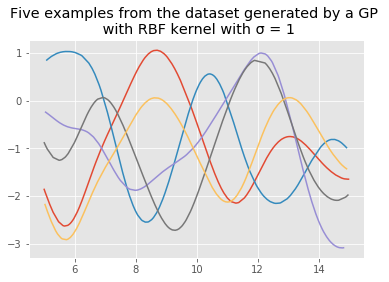

In [4]:
if d:
    plotter.plot_2d_examples(data[-3], data[-1], data[3])
else:
    plotter.plot_examples(data[3], data[-1])

In [7]:
train_step, test_step, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [8]:
# Uncomment the two lines below for one batch to overfit on
# np.random.seed(443)
# b_data, c = batch_creator.create_batch_2d(data[2], data[-3], data[-1], batch_s=20, em_2 = data[3])

### Training

Does not exist
New folder /Users/omernivron/Downloads/GPT_rbf/ckpt/check_run_3
Initializing from scratch.


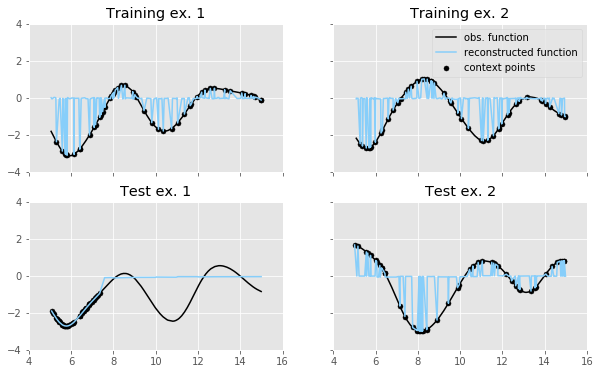

Epoch 0 batch 0 train Loss 1.0862 test Loss 0.7572 with training MSE metric 1.9966 and testing MSE metric 1.5444
learning rate is 0.0003000000142492354


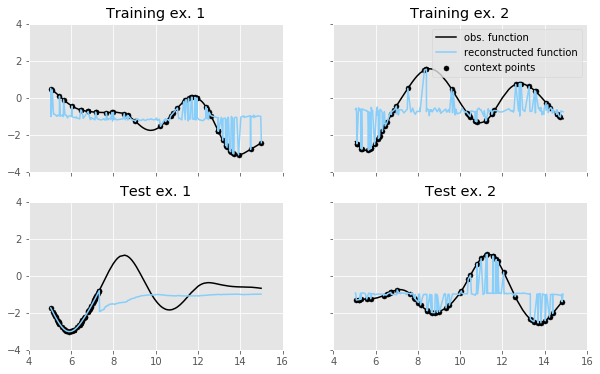

Epoch 0 batch 100 train Loss 0.4901 test Loss 0.5242 with training MSE metric 1.3162 and testing MSE metric 1.3633
learning rate is 0.0003000000142492354


In [ ]:
if __name__ == '__main__':
    tf.random.set_seed(443); step = 0
    # change to run 9 if you want to overfit
    EPOCHS = 75; batch_s  = 64; run = 3; tr_regime ='shuffle'
    l= [256, 64, 32]; heads = 32; e = 512; context = 50
    decoder, optimizer_c, ckpt, manager, num_batches, writer, folder = helpers.pre_trained_loader(data[3], save_dir, e, l, d=d, batch_s=64, context=context, heads=1, run=run)
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()
            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    b_data, c = batch_creator.batch_regime_2d(x = data[-3], y = data[-1], em = data[2] , em_2 =  data[3], batch_s=64, context_p=50, kind='shuffle')
                    # add parameter b=20 to helpers.gather_idx if you want to overfit and comment line above
                    to_gather = helpers.gather_idx(c)
                    temp = np.zeros((b_data[0].shape[0], b_data[0].shape[1]))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=temp)
                else:
                    b_data = batch_creator.create_batch(em_x = data[1], x = data[3], y = data[-1], batch_s=64, d=d)
                    to_gather = helpers.gather_idx(context, l=200)
                    temp = np.zeros((b_data[0].shape[0], b_data[0].shape[1]))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], to_gather = temp)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context, heads)
                if batch_n % 100 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        b_data_te, c_te = batch_creator.batch_regime_2d(x = data[-4], y = data[-2], em = data[0] , em_2 =  data[1], batch_s=64, context_p=context, kind=tr_regime)
                        to_gather_te = helpers.gather_idx(c_te)
                        temp_te = np.zeros((b_data_te[0].shape[0], b_data_te[0].shape[1]))
                        temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=temp_te, d=True)
                        ## Plotting progress by looking at a random test case. Erase _te from the six lines below if you rather observe training

                        if to_gather_te is not None:
                            # change 64 to 20 if you are overfitting
                            idd = np.random.choice(np.arange(0, 64))
                            seq_l = to_gather_te[to_gather_te[:, 0] == idd][0, 1]
                            plt.scatter(b_data_te[1][idd, :seq_l], b_data_te[0][idd, :seq_l] , c = 'blue', label = 'context')
                            plt.scatter(b_data_te[1][idd, seq_l:], b_data_te[0][idd, seq_l:], c = 'black', label = 'observed func.', alpha=0.5)
                            plt.scatter(b_data_te[1][idd, seq_l:], pred_te[idd][(seq_l - 1):], label = 'predicted func.')
                            plt.legend()
                            plt.show()
                        else:
                            plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = data[2][:64, :], y_te = data[-2][:64, :], to_gather = temp)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = data[2][:64, :], y_te = data[-2][:64, :], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    if d:
                        m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
                        m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
                        print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
                        print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

### Embeddings in tensorboard

In [ ]:
helpers.tensorboard_embeddings(decoder, layer_num = 0, meta_data = np.concatenate(([0, 1], np.unique(b_data[2]))))

### Inference

att:  (1, 32, 250, 250)
unique:  tf.Tensor(
[ 41 245  40 242 243  66  65  73  67  68  71  72  83  84 174 248  45  46
  50  52  47 249  48  49  51  53  42 246 247  59  60 233  27 223   8  19
 211 212   9  38 239 240 241  35  54  55  57  58  63  56  61  62  28  29
 228 235 244  36  37  80  81  79  75  76 204  20  21  15  16  43  44 162
 163 164 159 165   6   7 201 202  17  39  33  34 234  64], shape=(86,), dtype=int32)
count:  tf.Tensor(
[2 2 4 2 2 4 2 1 2 1 2 1 1 1 1 4 4 4 7 6 2 2 7 5 6 6 5 3 3 2 2 1 2 1 1 1 1
 1 1 2 2 1 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1], shape=(86,), dtype=int32)
att:  (1, 32, 251, 251)
unique:  tf.Tensor(
[ 41 245  40 242 243  66  65  73  67  68  71  72  83  84 174  45  46 248
  50  52 249  47 250  48  51  49  53  42 246 247  59  60 233  27 223   8
  19 211 212   9  38 239 240 241  35  54  55  57  58  63  56  61  62  28
  29 228 235 244  36  37  80  81  79  75  76 204  20  21  15  16  43  44
 162 163 164 159 165 

att:  (1, 32, 264, 264)
unique:  tf.Tensor(
[173 172 168 170 171  66  68  69  70  65  23 219 220 221  13  45  46 248
  50 254  47 249  48  52 256  51 263  59  60  58  53  64  67 255 257  43
 169 174 165 166 167  74 152 153 154 155 156  54  55 258  57 260 261 262
 236 237 238  39 235  63  61  62  73  75  35  36  37  33  79  80  81  41
 245  40  42 246 162 163 164 159   0   1 200   6   7 250 251  44], shape=(88,), dtype=int32)
count:  tf.Tensor(
[1 1 1 1 1 3 2 2 2 4 1 1 1 1 1 3 3 3 5 5 1 1 1 3 3 4 3 4 4 5 2 3 2 3 4 2 1
 1 2 1 1 2 1 1 1 1 1 2 2 2 4 3 3 2 1 1 1 2 1 3 3 2 1 2 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(88,), dtype=int32)
att:  (1, 32, 265, 265)
unique:  tf.Tensor(
[173 172 168 170 171  66  68  69  70  74  10  11  12 205  23  45  46 248
 263 264  50 254  47 249  48  52 256  51  59  60  58  64  67  65 255  53
 257  43 169 174 165 166 152 153 154 155 156  54  55 258  57 260 261 262
 236 237 238 235  35  63  61  73  39  36  37  79  80  81  75 150  41 245
  40  42 

att:  (1, 32, 276, 276)
unique:  tf.Tensor(
[173 172 168 170 171 270 271 273 274 275  10  11  12 205  15  82  97  98
  99  88  45  46 248  50 254  52 256  51  89  96  93  64 269 265  59  60
  53 255 257  43 169 165 166 167 174  67  68  69  70  74  66  54  55 258
  48  61  62 267  83  84  77  73  78  63  58 111 112 113 105 106  75  76
  65 272  90  91  92  94 100 107 108  85 162 163 164 159 263 264  13  14
  80  81  79  41 245 242 243 244], shape=(98,), dtype=int32)
count:  tf.Tensor(
[1 1 1 1 1 3 3 3 3 2 2 2 2 1 1 3 4 4 4 4 1 1 1 2 2 1 1 2 3 3 3 2 2 2 2 2 1
 1 2 1 1 3 1 1 1 2 1 1 1 3 2 1 1 1 1 3 3 1 2 2 2 2 1 3 2 1 1 1 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1], shape=(98,), dtype=int32)
att:  (1, 32, 277, 277)
unique:  tf.Tensor(
[173 172 168 170 171 276 270 271 273 274  10  11  12 205  15  82  97  98
  99  88  45  46 248  50 254  52 256  51  89  96  93  64 269 265  59  60
  53 255 257  43 169 165 166 167 174  67  68  69  70  74  66  54  55 258
  48  61  62 267  83 

att:  (1, 32, 288, 288)
unique:  tf.Tensor(
[173 172 168 170 171 276 277 278 270 271  10  11  12 205  20  97  98  99
  88  82  89 100  93  94  95  52 256  50 254  51  53  79  75  76  80  81
 255 257  56 169 174 165 166  67 280 281 282  74  66  48  49 252 253  45
  61  62 267  83  84  77  78  73 286 287  96  64 273 111 112 113 110 105
 279 274  65 272  90  91  92 106 107 108  85 162 163 164 159  63 263 264
 265  58  57 260 250 251  40  43  44  87  41 245 242 243], shape=(104,), dtype=int32)
count:  tf.Tensor(
[2 1 1 1 1 2 2 2 3 3 1 1 1 1 1 4 4 3 4 2 4 2 3 2 1 2 2 1 1 2 2 2 2 2 3 3 1
 1 1 1 1 2 1 2 1 1 2 2 2 1 1 1 1 1 2 2 1 2 2 2 1 2 2 2 2 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1], shape=(104,), dtype=int32)
att:  (1, 32, 289, 289)
unique:  tf.Tensor(
[173 172 168 170 171 276 277 278 270 271  10  11  12 205  15  97  98  99
  88  83  89 101 102 103 104  52 256  50 254  51  53 257  79  75  76  80
  81 255  56 169 165 166 167 174  67 280 281 288 282  66

att:  (1, 32, 300, 300)
unique:  tf.Tensor(
[173 172 168 170 171 276 277 278 270 271  10  11  12 205  22  97  98  99
  87  82  89 100 101 102 103  52 256  50 254  58  88  53 257  79 297  80
  81 298  56 259  51 169 174 165 166 167  67 280 281 288  68  75  76 289
 290 291 104 269  74  83  84  77  78  73 286  96  93  66 287 273 111 112
 113 110 105 279  65 272  90  91  92  94 106 107 108 159 162 163 164 263
  63  85  86 265  59  60 266 146  54 299  41 245 242 243 244], shape=(105,), dtype=int32)
count:  tf.Tensor(
[1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 5 5 5 3 2 5 3 2 2 2 2 2 2 1 1 3 2 2 1 1 2 2
 2 1 1 1 1 1 1 1 1 2 2 2 3 1 1 1 1 1 1 1 1 4 1 1 1 1 2 2 2 3 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1], shape=(105,), dtype=int32)
att:  (1, 32, 301, 301)
unique:  tf.Tensor(
[173 172 168 170 171 276 277 278 270 271  10  11  12 205  22  97  98  99
  87  82  89 100 101 102 103  52 256  50 254  58  88  53 257  79 297  80
  81 298  56 259  51 169 174 165 166 167  67 280 2

att:  (1, 32, 313, 313)
unique:  tf.Tensor(
[ 41 245  40 242 243 177 110 111 112 113  10  11  12 205  20  87 310 305
  97  98 312  89  93  94  95 197 191 193 194 195  88 311  53  33  34 234
 304  83  84 306 198 192 188 189  45  46 248  48  49  67 280 281 282 288
 114 115 116 119 120 100 109 101 102  90  91  92  82 302 303 307 308  85
  86  96  99  66  73 286 287 273 199 186 279 276 277 278  74  75 105 106
 107 108 159 162 163 164 165 265  63  59  60 266  54 274 270 271], shape=(106,), dtype=int32)
count:  tf.Tensor(
[2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 3 4 4 1 4 6 3 2 3 2 1 1 1 4 4 1 1 1 1 2
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 2 1 1 1 2
 2 1 1 1 1 2 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1], shape=(106,), dtype=int32)
att:  (1, 32, 314, 314)
unique:  tf.Tensor(
[ 41 245  40 242 243 177 110 111 112 113  10  11  12 205  20  87 310 305
  97  98 312 313  89  93  94 197 191 193 194 195  88 311  53  33  34 234
 304  83  84 306 198 192 188 189  45  46 248

att:  (1, 32, 325, 325)
unique:  tf.Tensor(
[ 41 245  40 242 243 123 124 120 125 126  10  11  12 205  19  87 310  97
  98  99  89 312 313 314 315 197 191 193 194 195 117 118 114  22 216  17
  18 210 110 321 322 109 198 192 188 189 223 224 233  27 225 115 116 119
 199 187 105 106 107 108 319  82 302 303 307 308 111 112 113 323 324  96
  93 121 122 159 160 161 294 295 296 304  75  90  91  92 101 102 279  71
  72 284 285 320  39  64  59  60 266 265  88 311 173 179], shape=(104,), dtype=int32)
count:  tf.Tensor(
[1 1 1 1 1 2 2 3 1 1 1 1 1 1 1 2 2 4 4 4 2 2 2 2 2 3 3 2 1 1 5 2 4 1 1 1 1
 1 2 2 2 2 3 2 1 1 1 1 1 1 1 3 3 2 2 1 3 3 1 1 1 1 1 1 2 1 1 1 1 1 1 3 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(104,), dtype=int32)
att:  (1, 32, 326, 326)
unique:  tf.Tensor(
[ 41 245  40 242 243 123 124 120 125 126  19 211 212  10  11  87 310  97
  98  99  89 312 313 314 315 197 191 193 194 195 110 321 322 117  22 216
  17  18 210 118 198 192 188 189 223 224 233 225 226 114

att:  (1, 32, 337, 337)
unique:  tf.Tensor(
[173 168 172 170 171 127 131 334 332 132  73 286 287  74 294 151 152 153
 160 161 143 144 140 141 142  45  46 248  50 254 135 138 139 145 333 125
 335 136  42 246 247  40  41  24 217 218 223 224 123 119 114 115 116 154
 155 156  63  58  57 260 261 133 146 134 137 121 122 124 118 331 250 251
 159 162 163 164 157 158 336 148 149 147 150  71  72 284 285 100 317 198
 109 105  87 310 304 305  82 128 129 130 169 165 166 167], shape=(104,), dtype=int32)
count:  tf.Tensor(
[2 1 1 1 1 2 3 3 4 4 1 1 1 1 2 1 2 2 2 1 1 1 4 3 2 1 1 1 1 1 7 4 4 4 1 1 2
 4 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 3 2 3 2 2 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(104,), dtype=int32)
att:  (1, 32, 338, 338)
unique:  tf.Tensor(
[173 172 168 170 171 127 131 334 132 336  73 286 287 282  74 151 152 153
 160 161 143 144 140 141 142  45  46 248  50 254 135 332 145 333 124 138
 337 136 335  40  42 246 247  41 217 218  24  20  21 123

att:  (1, 32, 349, 349)
unique:  tf.Tensor(
[173 172 168 170 171 131 334 127 132 336  22 216  23 219 220 160 161 151
 152 153 143 144 140 141 142  45  46 248  52 256 174 175 159 154 155 156
 157  51 255  42 246 247 169 165 166 167  57 260 261 262  54 150 147 146
 136 340 341 137 342 135 138 139 343 344 145 346 347 348 134 339 335 332
 333 162 163 164 133 338 337 148 149  61  62 267 268 263 193 194 195 196
 198 125], shape=(92,), dtype=int32)
count:  tf.Tensor(
[5 4 4 3 2 2 2 1 2 1 1 1 1 1 1 6 4 3 2 2 1 1 2 2 2 1 1 1 1 1 2 2 3 6 4 3 2
 1 1 1 1 1 1 3 3 2 1 1 1 1 1 2 4 3 1 1 1 2 1 2 1 1 1 1 2 2 2 2 2 2 1 1 1 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(92,), dtype=int32)
att:  (1, 32, 350, 350)
unique:  tf.Tensor(
[173 172 168 170 171 131 334 127 132 336  23 219 220 221  20 160 161 152
 153 151 143 144 140 141 142  45  46 248  52 256 135 145 346 347 348 159
 154 155  42 246 247  40  51 169 174 165 166 175 167  57 260 261 262  54
 150 147 146 136 340 341 137 138 139 343 134 339 333 335 

att:  (1, 32, 361, 361)
unique:  tf.Tensor(
[173 172 168 170 171 174 177 169 162 163  22 216 217 218  20 160 161 152
 153 357 143 144 140 141 142  45  46 248  52 256 355 356 360 198 175 332
 159 154 155  42 246 247  51 255 165 166 167  57 260 261 262 257 150 350
 351 352 137 342 136 340 341 145 346 347 348 135 134 339 335 333 125 345
 147 156 157 146 133 338 337 148 149 349 164 199 197 193 194 126 132 336], shape=(90,), dtype=int32)
count:  tf.Tensor(
[6 5 4 2 2 2 1 4 2 2 1 1 1 1 1 5 4 1 1 1 1 1 3 3 3 2 2 2 2 2 3 2 2 2 3 1 4
 3 2 1 1 1 1 1 3 3 2 1 1 1 1 1 2 2 2 2 1 1 1 1 1 3 2 2 2 1 1 1 1 2 2 1 3 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(90,), dtype=int32)
att:  (1, 32, 362, 362)
unique:  tf.Tensor(
[173 172 168 170 171 174 169 177  20  21  22 216  23 152 153 357 358 160
 143 144 140 141 142  45  46 248  52 256 161 151 353 354 145 346 347 348
 138 159 361 154  42 246 247  40  41 165 175 166 167 360  54  55 258  57
 260 150 350 351 352 355 137 342 136 340 341 179 135 134 339 335 132 3

att:  (1, 32, 374, 374)
unique:  tf.Tensor(
[173 369 370 371 172 177 174 169 175  22 216  20  21  19 182 179 183 191
 188 193 194 195 196 192 197 199 145 346 347 348 127 366 160 161 362 190
 198 168 367 170 171 368 165 166 167 363 189 150 350 351 352 355 146 159
 361 181 184 152 153 357 154 155 156 157 158 187 185  66 279  71  72 284
 162 163 164 365 178 180 176 124 125 126 333 128], shape=(84,), dtype=int32)
count:  tf.Tensor(
[5 5 5 4 3 2 2 3 1 1 1 1 1 1 3 4 2 5 6 4 3 1 1 3 4 5 2 2 1 1 1 1 3 3 3 2 4
 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 5 4 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1], shape=(84,), dtype=int32)
att:  (1, 32, 375, 375)
unique:  tf.Tensor(
[173 369 370 371 172 177 374 174 175  20  21  22 216  10 179 182 183 181
 193 194 195 196 192 197 191 145 346 347 348 138 366 160 161 362 190 199
 198 169 168 367 170 171 368 165 166 167 363 188 189 150 350 351 352 154
 146 184 159 361 155 187 185  71  72 284 285 279 162 163 164 365 178 180
 124 125 126 333 131], shape=(77,

att:  (1, 32, 387, 387)
unique:  tf.Tensor(
[173 369 370 371 172 177 374 376 377  19 211 212  22 216 182 183 381 188
 189 193 194 195 196 192 197 191 179 379 333 125 126 127 332 199 198 190
 169 366 170 171 368 168 367 184 185 382 386 152 153 357 358 159 154 155
 156 157 158 384 385 187  71  72 284 285  75 160 161 362 361 150 350 351
 352 378 383 178 375 180 124], shape=(79,), dtype=int32)
count:  tf.Tensor(
[4 3 3 2 2 1 1 1 1 1 1 1 1 1 3 2 2 8 5 4 4 3 1 5 9 6 2 1 2 2 2 1 1 7 6 3 1
 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 1 1 1 1], shape=(79,), dtype=int32)
att:  (1, 32, 388, 388)
unique:  tf.Tensor(
[173 369 370 371 172 376 377 177 374 183  19 211 212  22 216 188 189 197
 191 182 193 194 195 196 192 179 379 333 125 126 127 199 387 198 169 366
 170 171 368 168 367 184 185 382 190 386 159 361 152 153 381 162 163 164
 365 154 155 156 157 158 384 187 385  71  72 284 285  75 160 161 362 378
 383 178 375 180 124  15  16], shape=(79,), dtype=int32)
count:

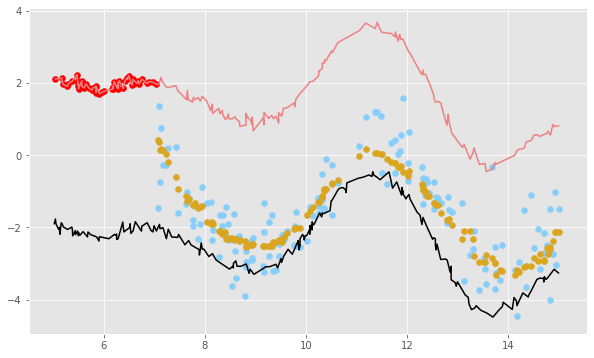

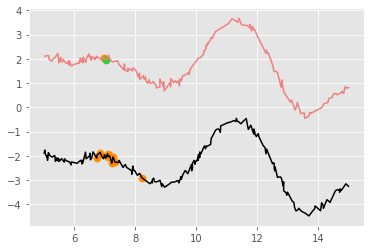

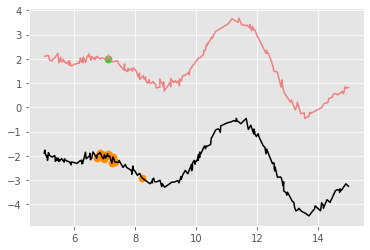

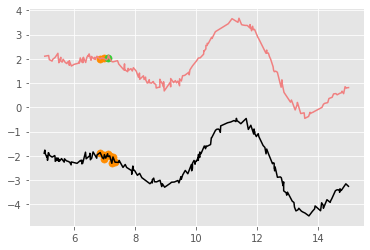

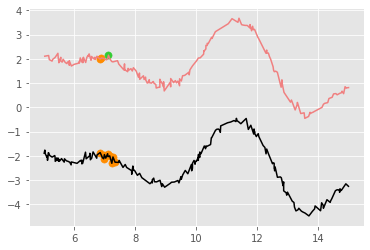

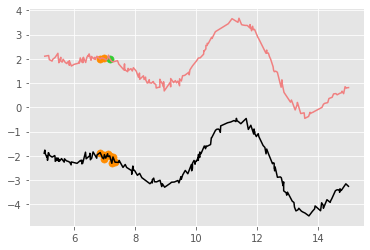

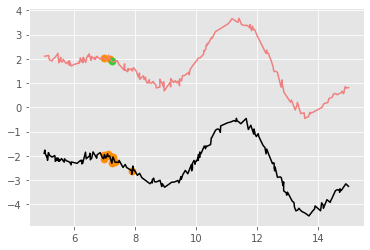

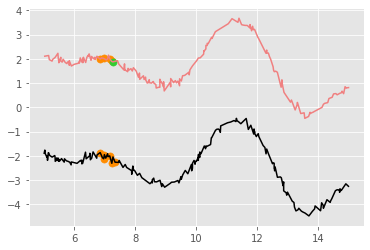

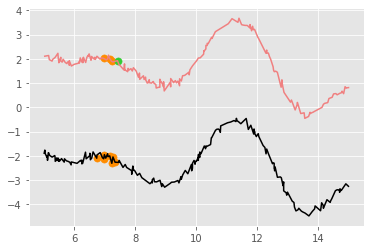

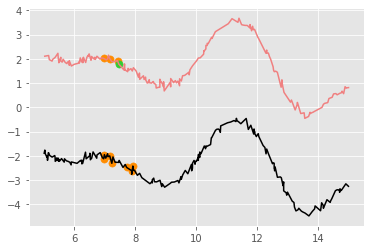

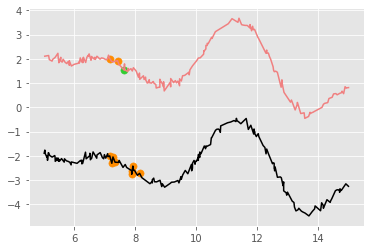

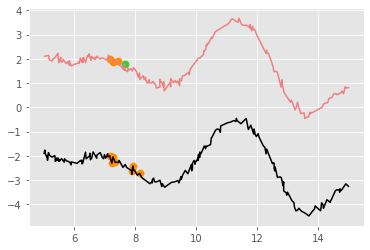

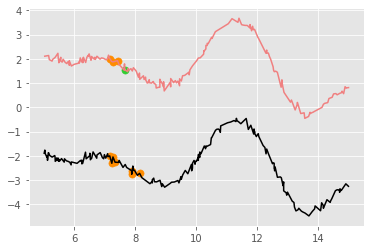

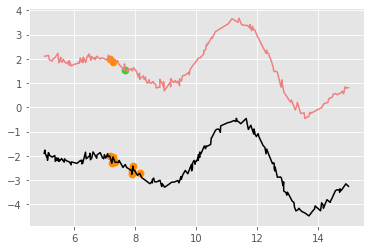

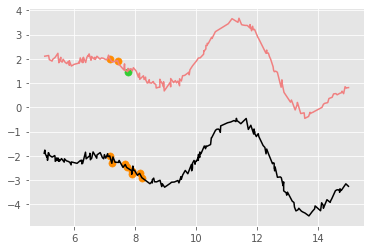

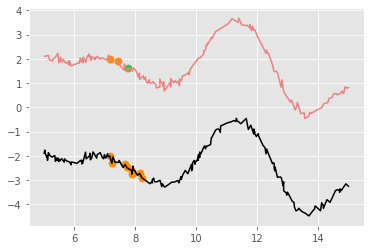

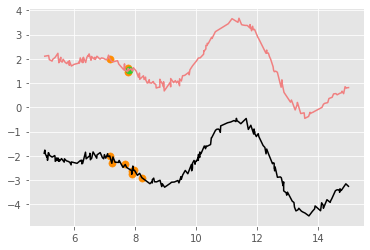

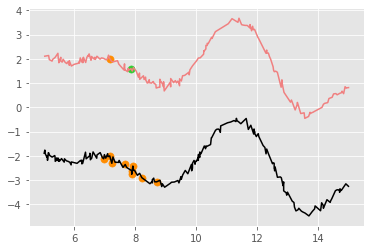

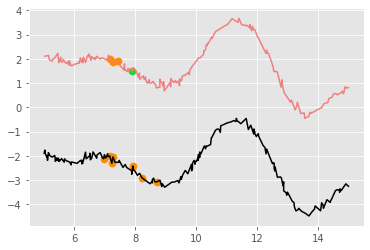

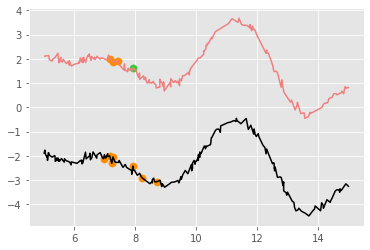

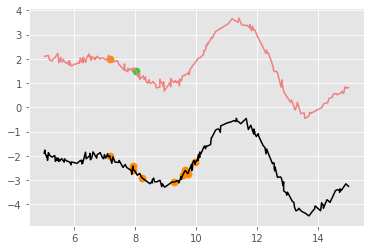

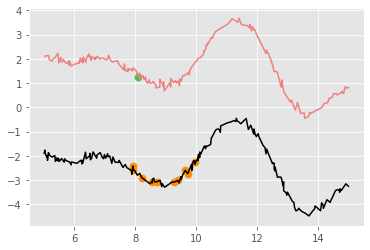

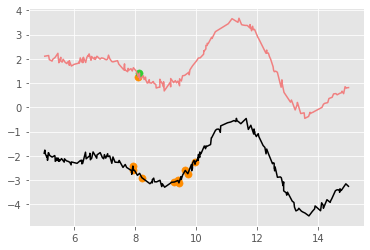

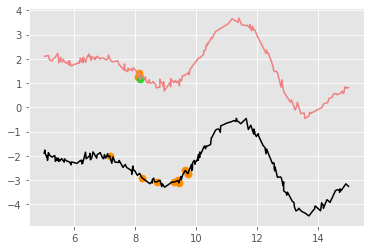

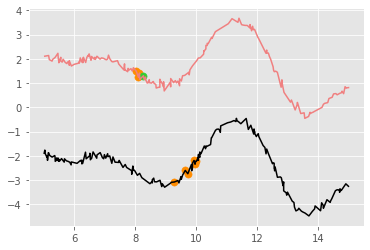

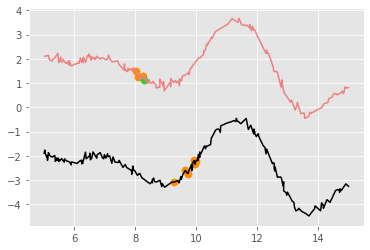

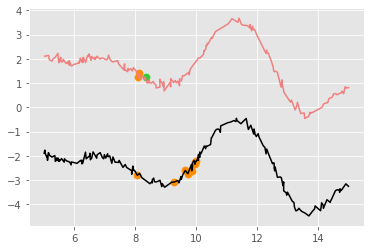

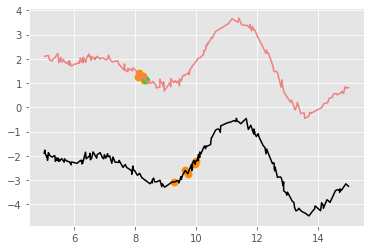

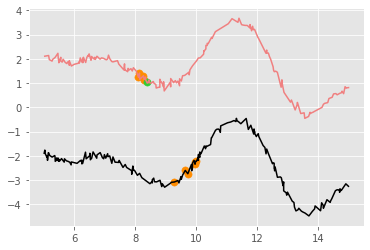

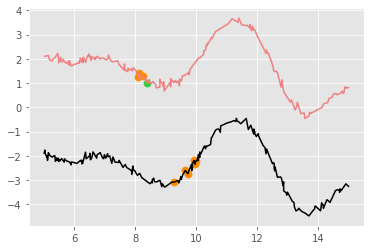

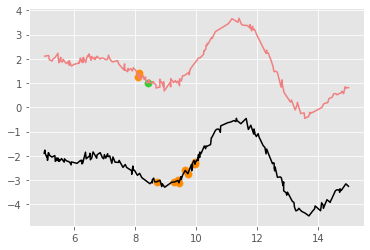

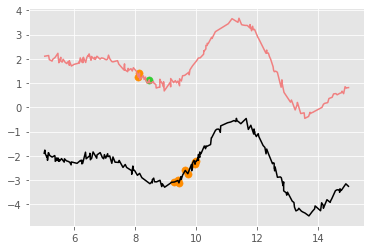

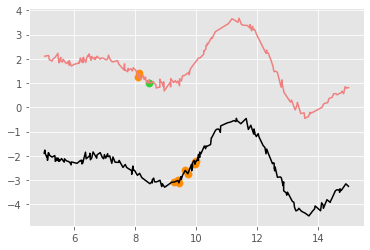

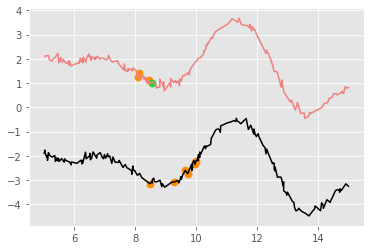

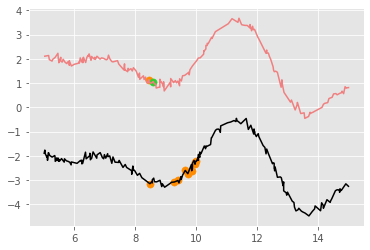

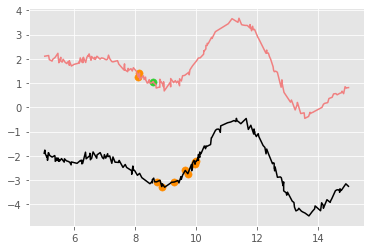

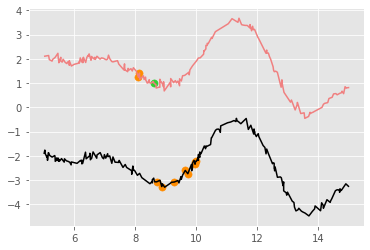

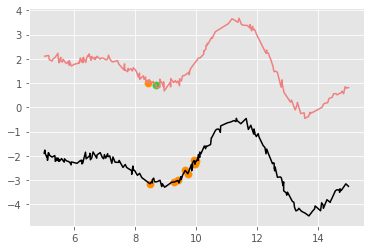

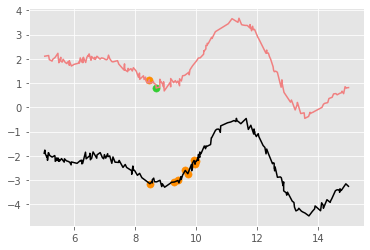

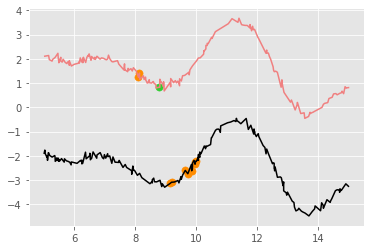

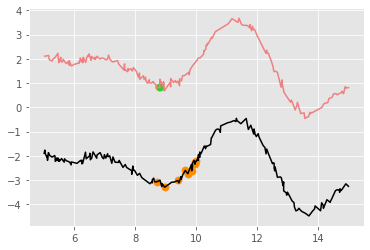

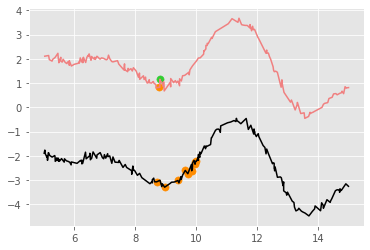

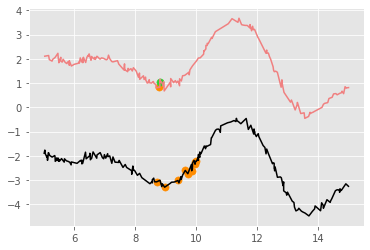

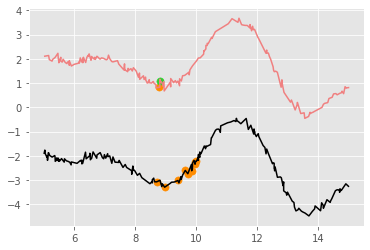

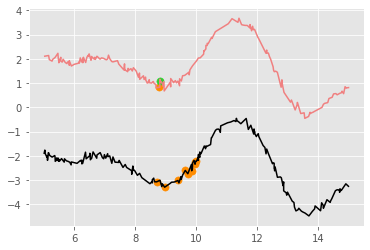

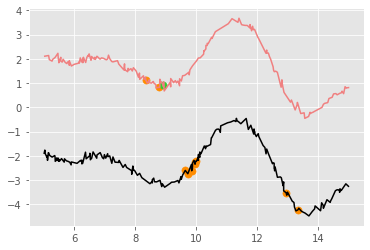

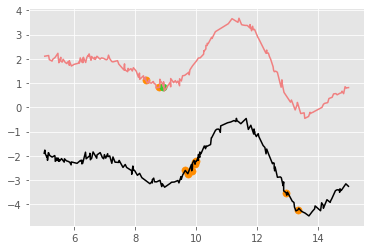

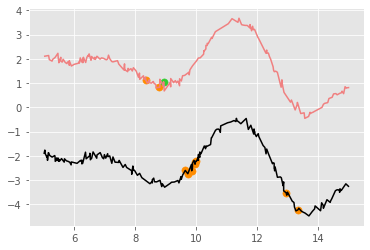

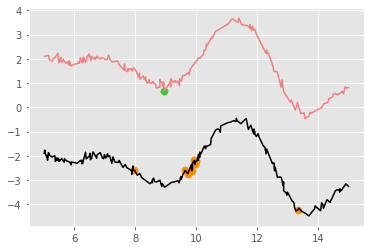

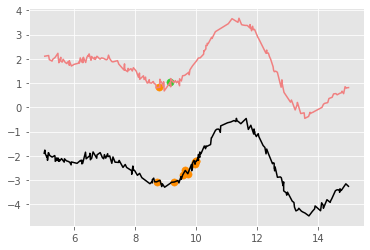

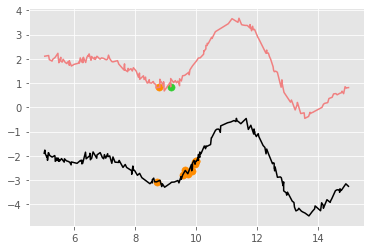

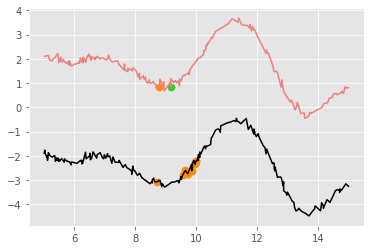

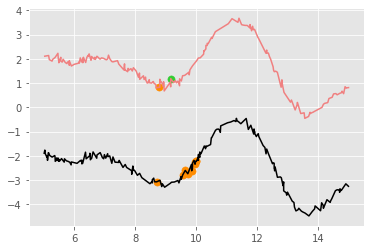

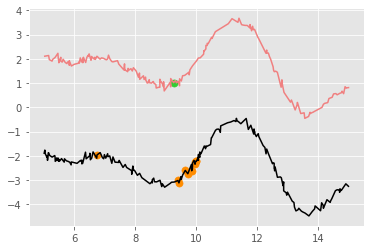

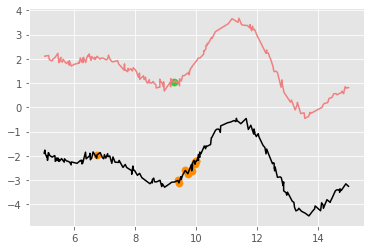

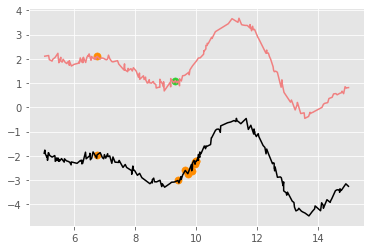

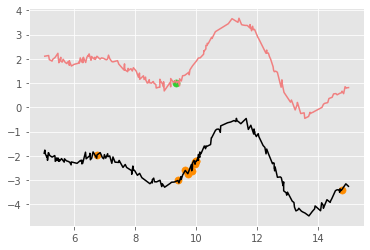

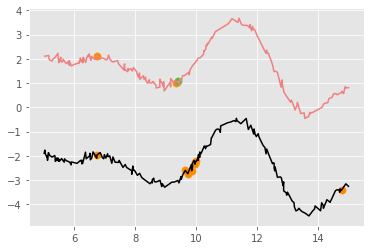

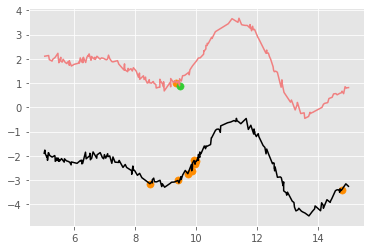

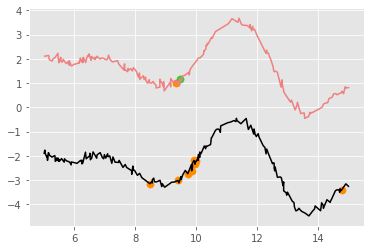

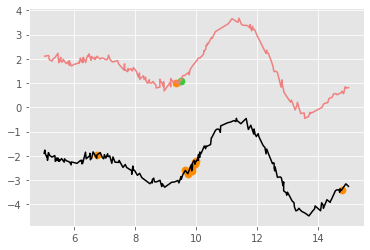

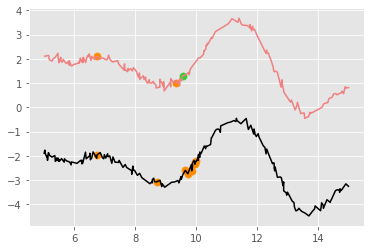

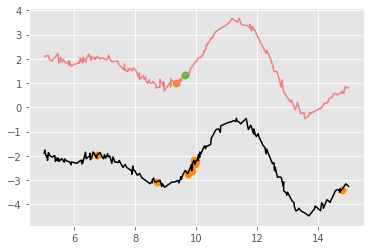

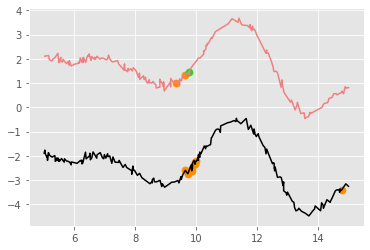

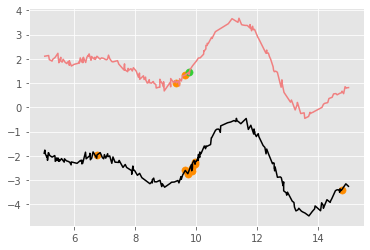

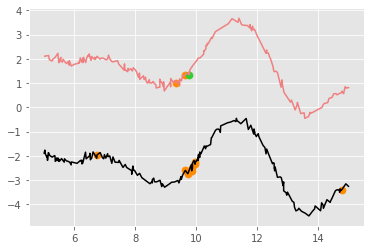

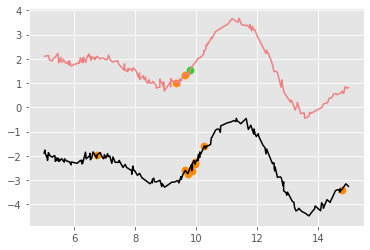

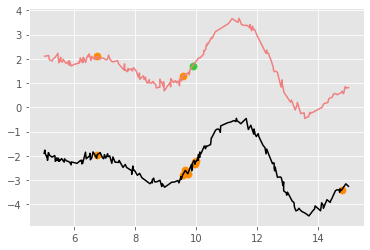

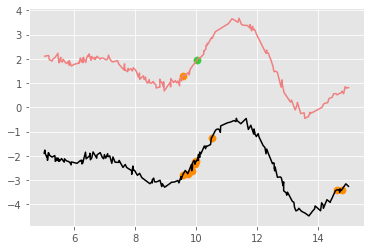

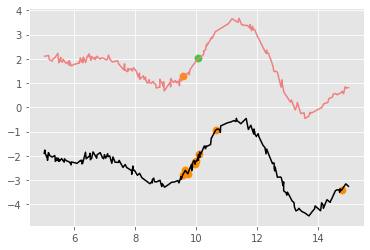

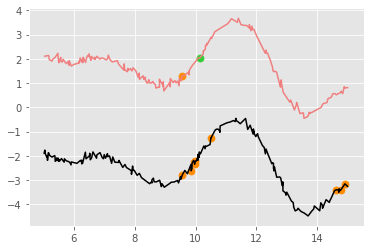

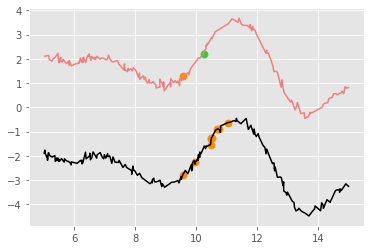

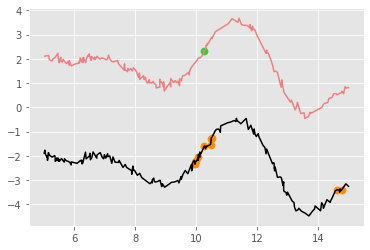

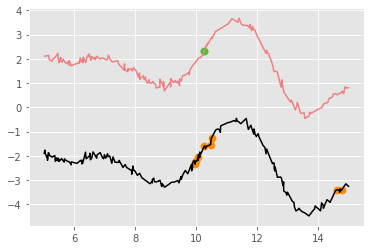

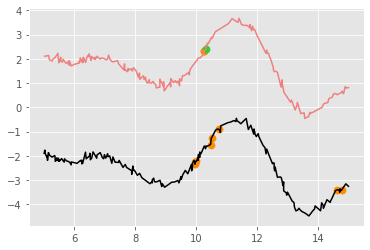

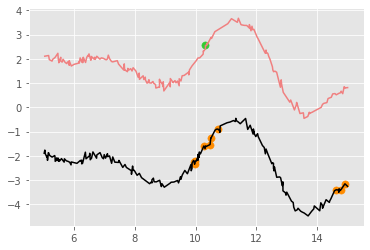

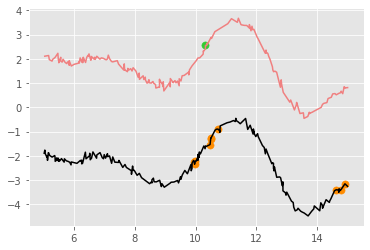

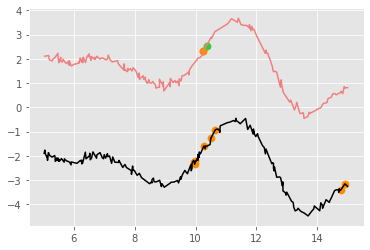

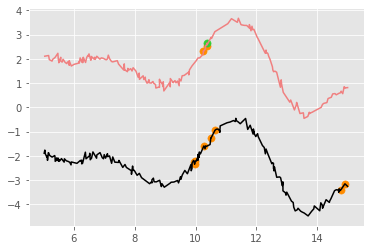

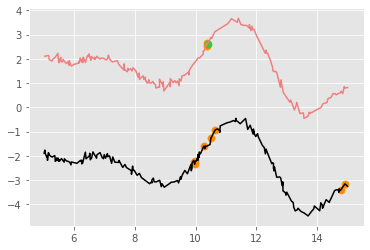

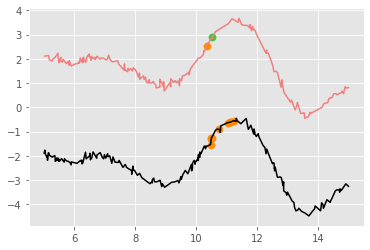

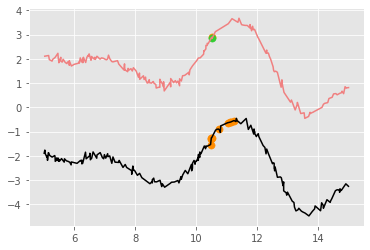

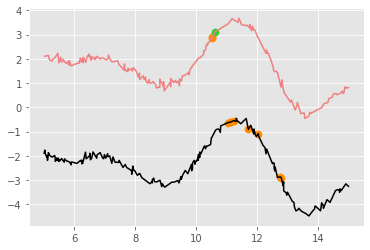

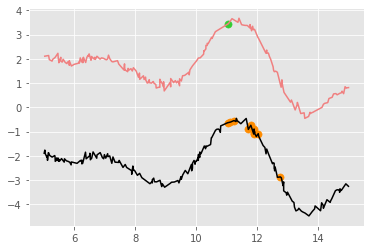

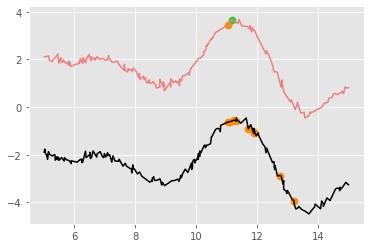

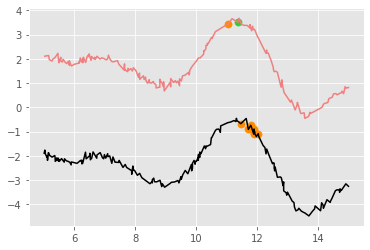

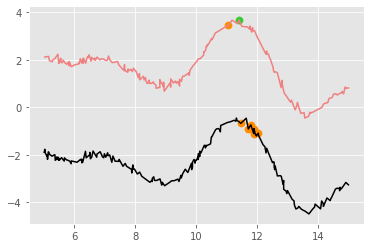

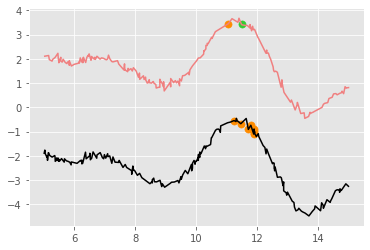

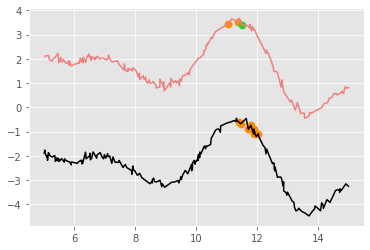

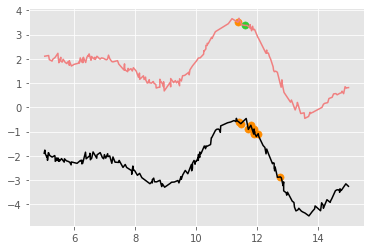

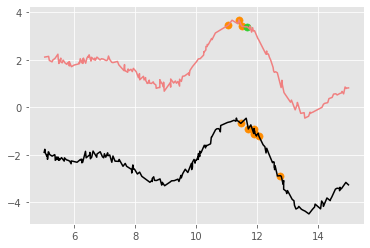

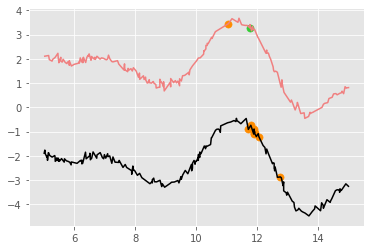

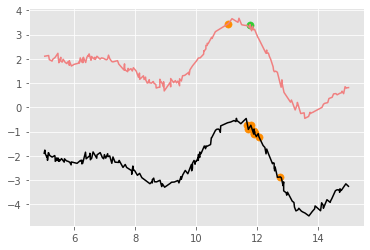

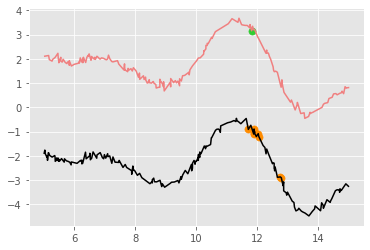

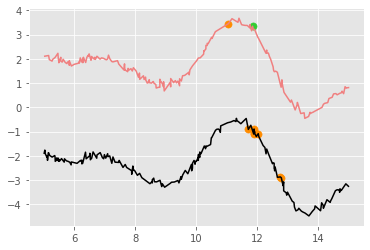

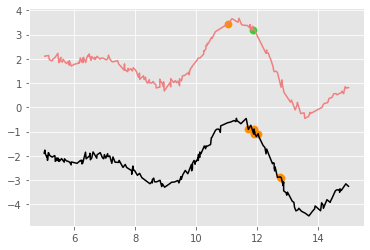

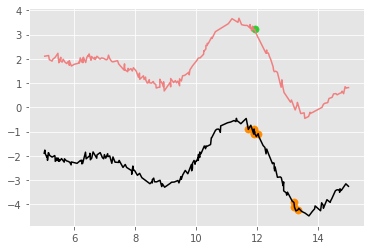

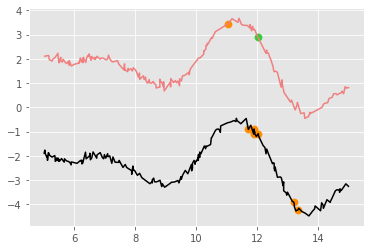

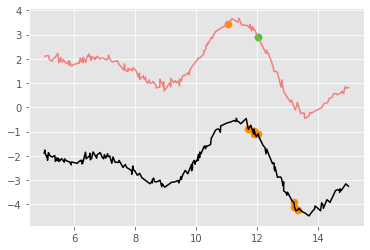

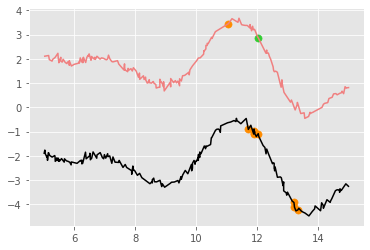

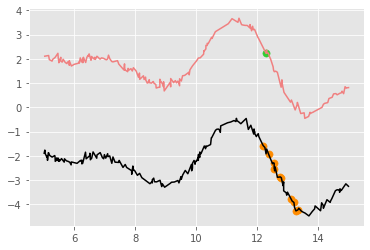

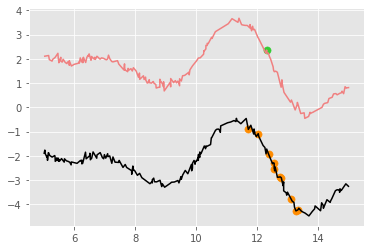

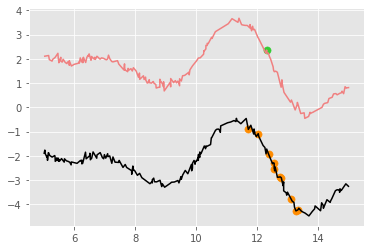

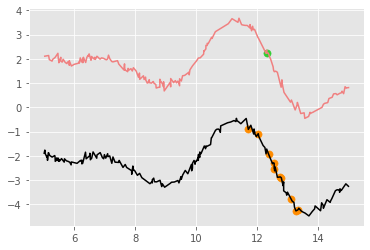

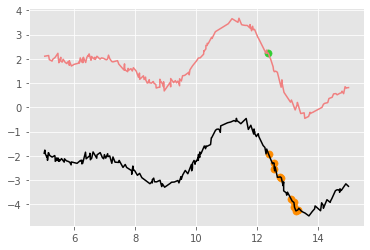

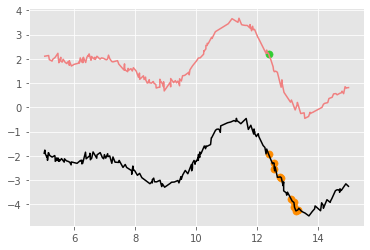

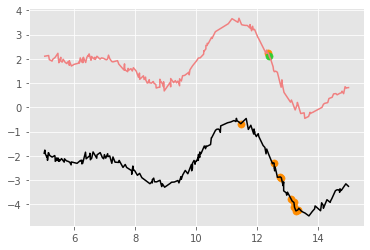

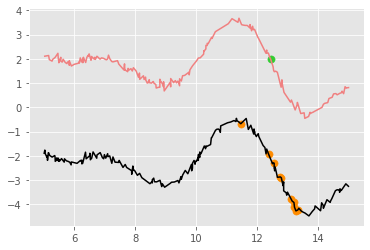

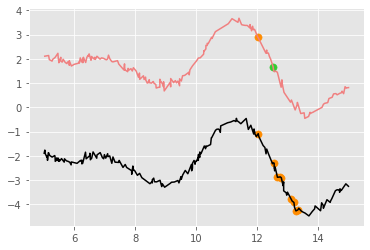

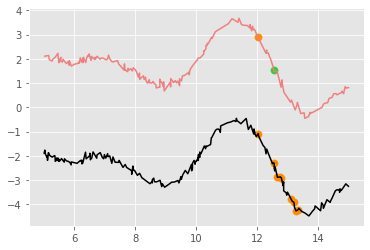

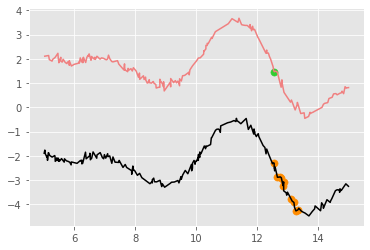

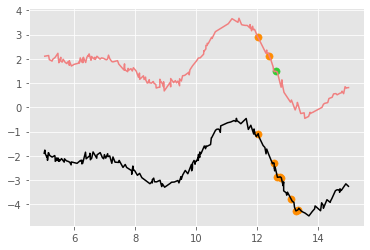

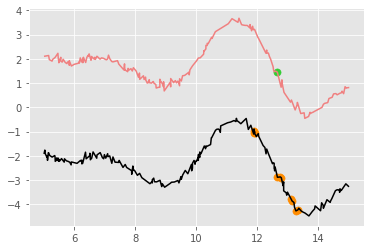

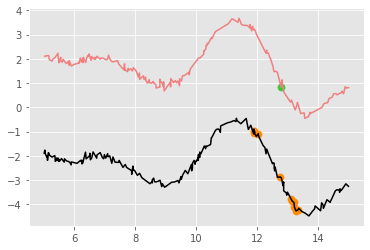

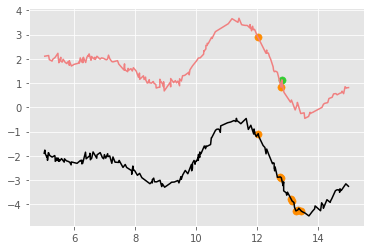

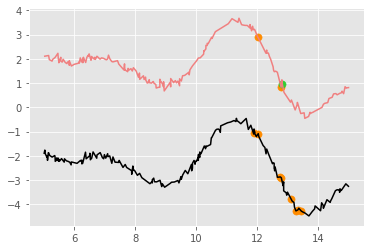

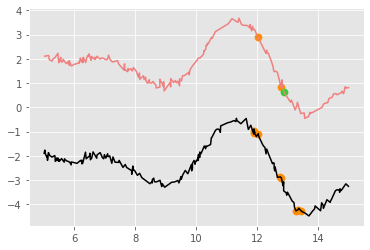

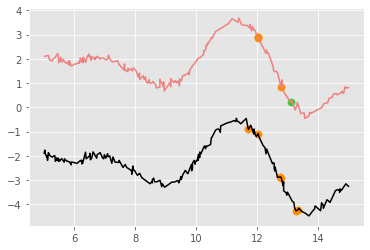

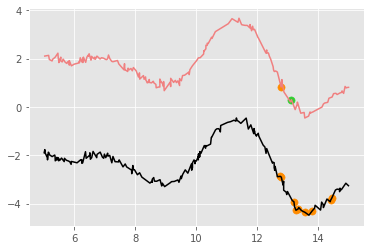

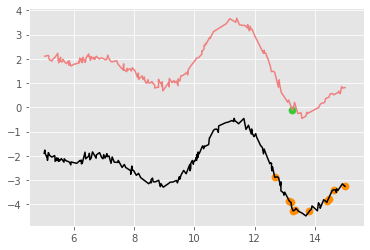

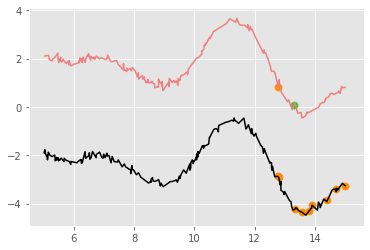

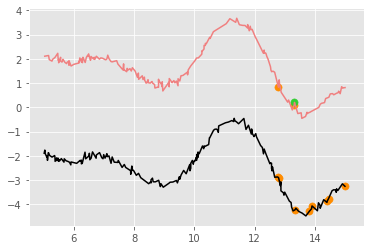

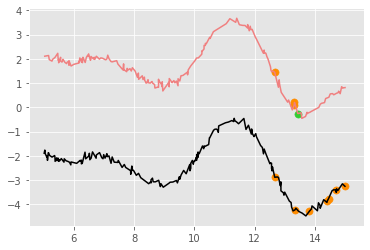

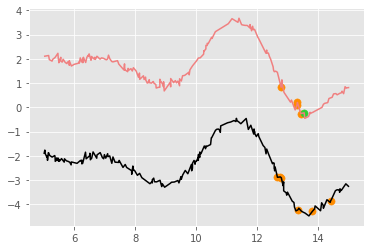

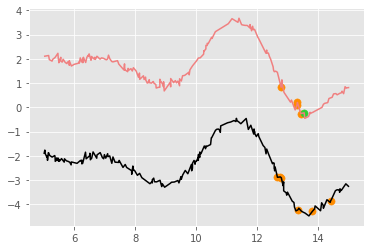

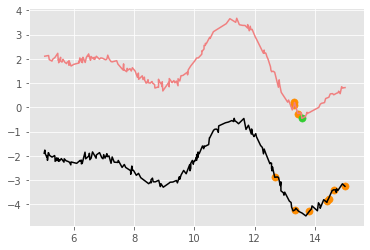

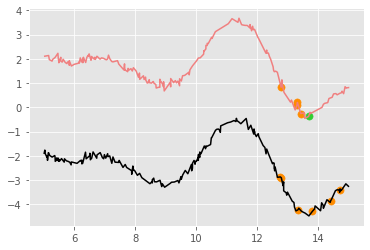

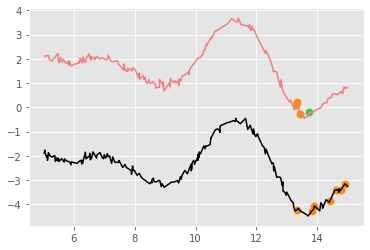

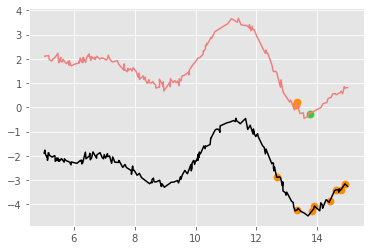

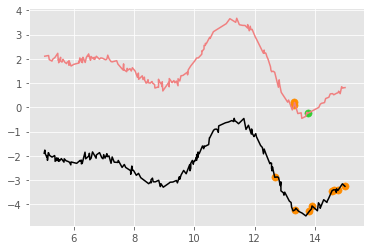

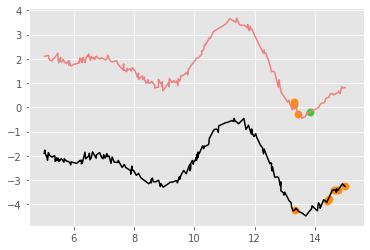

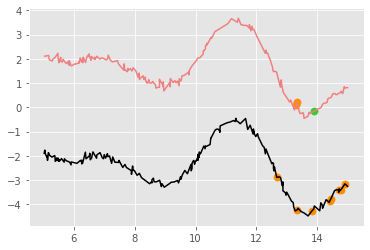

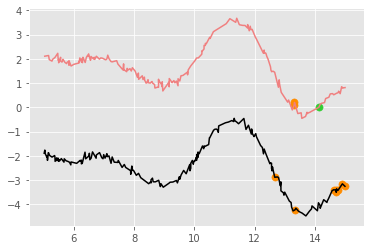

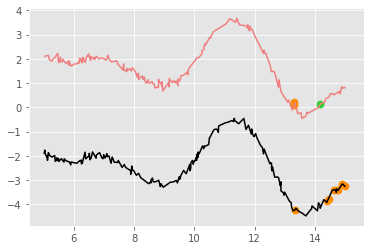

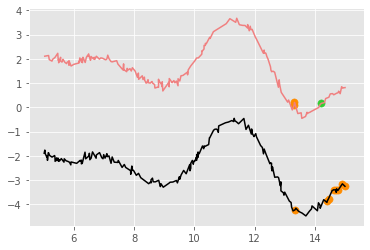

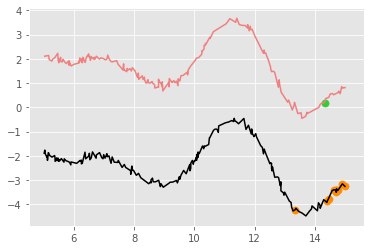

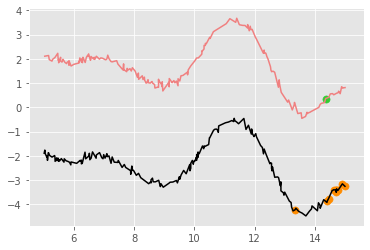

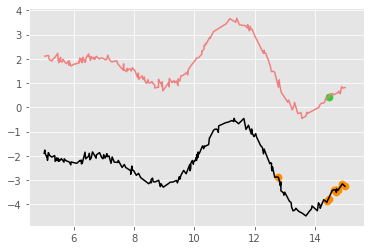

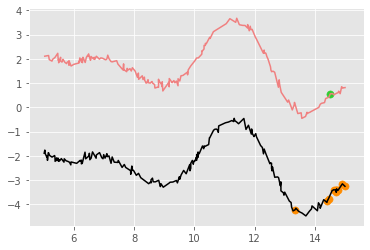

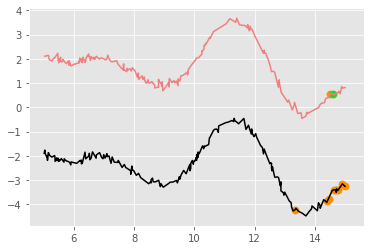

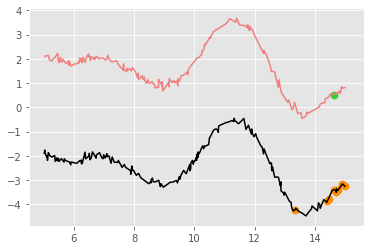

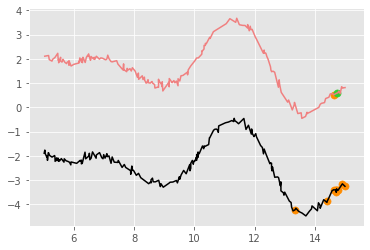

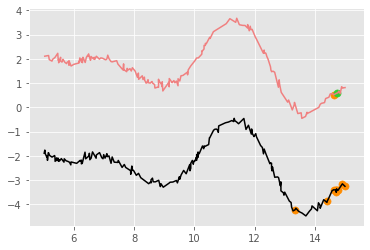

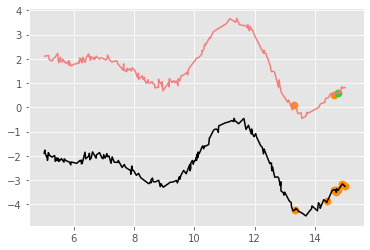

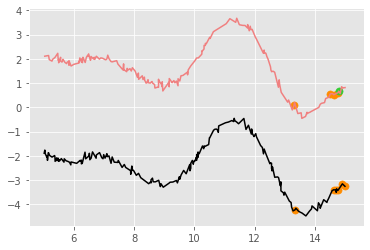

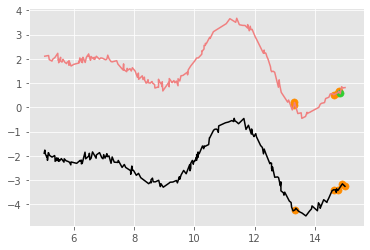

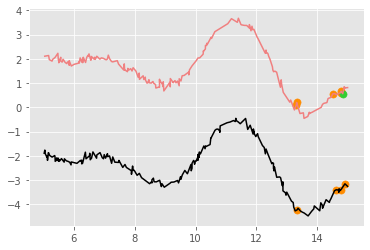

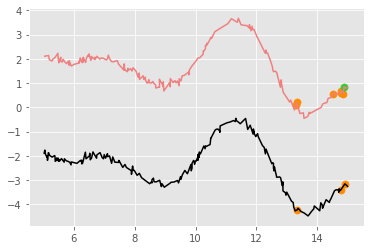

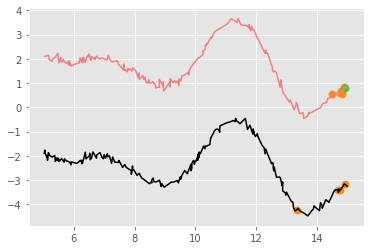

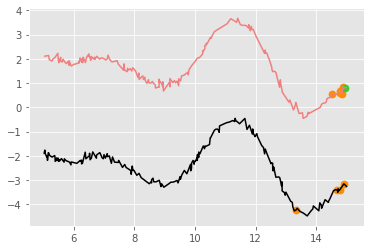

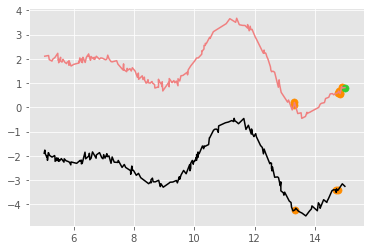

In [26]:
run = 7; l= [256, 64, 32]; e = 512; context = 50
decoder, optimizer_c, ckpt, manager, num_batches, writer, folder = helpers.pre_trained_loader(data[1], save_dir, e, l, d=True, batch_s=64, context=context, heads=1, run=run)
idx = int(np.random.choice(np.arange(0, 30000, 1), 1));
_ = plotter.infer_plot2D(decoder, data[-4][idx, :], data[-2][idx, :], data[0][idx, :], data[1][idx, :], samples = 1, num_steps = 999, consec = True, order = True, context_p = 50)